In [1]:
# ! pip install Sastrawi

## Import Libraries

In [2]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Train test split
from sklearn.model_selection import train_test_split

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

# Import library preprocessing data
import re
import nltk
from nltk import punkt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Import pickle untuk menyimpan model
import pickle

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
# Read Dataset
data = pd.read_csv('dataset.csv')

data.head()

,content,date,title,label
0,Berita SurabayaSURYA.co.id | SURABAYA - Pengem...,"Jumat, 10 Juni 2022 01:08",PT Intiland Development Kembangkan Kawasan Ind...,noclickbait
1,Berita SurabayaSURYA.co.id | SURABAYA - Brand ...,"Jumat, 10 Juni 2022 01:16",ANKER Menangkan Penghargaan Nobel Prize di Aja...,noclickbait
2,Berita SurabayaSURYA.co.id | SURABAYA - PT Har...,"Jumat, 10 Juni 2022 01:27","Perluas Bisnis, Hartadinata Abadi Store Buka G...",noclickbait
3,Berita SurabayaSURYA.co.id | SURABAYA – Peneri...,"Jumat, 10 Juni 2022 01:34","PPDB SMP Dibuka Hari Ini, Dindik Surabaya Mint...",clickbait
4,"SURYA.co.id I Masih ingat Ronaldo Nazario, san...","Jumat, 10 Juni 2022 01:51","Liga Spanyol, Ronaldo Legenda Real Madrid, Jad...",clickbait


In [4]:
data.describe(include='all')

,content,date,title,label
count,1600,1600,1600,1600
unique,1596,1532,1595,2
top,"SURYA.CO.ID, LAMONGAN - Kawasan Pantura (Panta...","Kamis, 20 Oktober 2022 09:15",Dideklarasikan Emak-Emak Lamongan di Pinggir K...,noclickbait
freq,2,3,2,800


In [5]:
# menambahkan column baru yang berisi biner (0/1) = (noclickbait/clickbait)
data['binary_label'] = pd.get_dummies(data.label)['clickbait']
data.head()

,content,date,title,label,binary_label
0,Berita SurabayaSURYA.co.id | SURABAYA - Pengem...,"Jumat, 10 Juni 2022 01:08",PT Intiland Development Kembangkan Kawasan Ind...,noclickbait,0
1,Berita SurabayaSURYA.co.id | SURABAYA - Brand ...,"Jumat, 10 Juni 2022 01:16",ANKER Menangkan Penghargaan Nobel Prize di Aja...,noclickbait,0
2,Berita SurabayaSURYA.co.id | SURABAYA - PT Har...,"Jumat, 10 Juni 2022 01:27","Perluas Bisnis, Hartadinata Abadi Store Buka G...",noclickbait,0
3,Berita SurabayaSURYA.co.id | SURABAYA – Peneri...,"Jumat, 10 Juni 2022 01:34","PPDB SMP Dibuka Hari Ini, Dindik Surabaya Mint...",clickbait,1
4,"SURYA.co.id I Masih ingat Ronaldo Nazario, san...","Jumat, 10 Juni 2022 01:51","Liga Spanyol, Ronaldo Legenda Real Madrid, Jad...",clickbait,1


In [6]:
data['binary_label'].value_counts()

0    800
1    800
Name: binary_label, dtype: int64

([<matplotlib.patches.Wedge at 0x23c11385c10>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'clickbait'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'noclickbait')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

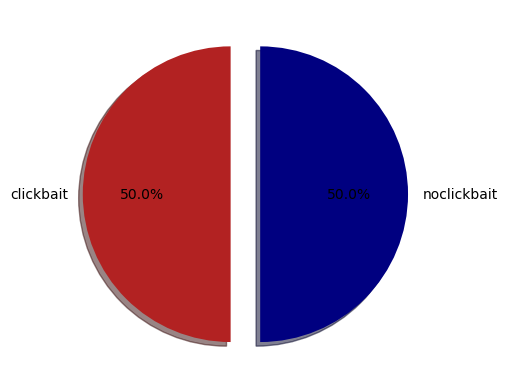

In [7]:
# Cek label data
label_size = [data['binary_label'].sum(),len(data['binary_label'])-data['binary_label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['clickbait','noclickbait'],autopct='%1.1f%%')

## Preprocessing data

In [8]:
# menggabungan teks judul dan isi berita
data['Combined'] = data['title'] + ' ' + data['content']

In [9]:
# contoh data yang sudah di combine
for i in data.loc[8][['title', 'content','Combined']]:
    print(i,'\n')

Anggota KKB Papua Ceroboh, Perannya Sebagai Pemasok Amunisi Terbongkar Gara-gara Bacok Warga Sipil 

SURYA.co.id - Gara-gara kecerobohannya sendiri, seorang anggota KKB Papua berhasil ditangkap aparat TNI -Polri.Tak hanya itu, perannya sebagai pemasok amunisi untuk KKB Papua juga ikut terbongkar.Penyebab awalnya adalah ia nekat membacok warga sipil di Intan Jaya pada April 2021 lalu.Polisi langsung menangkapnya dan akhirnya terbongkar perannya sebagai anggota KKB Papua yang bertugas memasok amunisi.Melansir dari laman tribratanews.polri.go.id, berdasarkan Informasi adanya keberadaan Tersangka Pembacokan Warga Intan Jaya pada April 2021 di Pertigaan Pasar Yokatapang, Tim Aparat Gabungan Ops Damai Cartenz 2020 melakukan pegecekan dan penyelidikan. Dari hasil pengecekan, tersangka terlihat di Kali Wabu, Rabu (08/06/2022).Selanjutnya, tim bergerak dan berhasil mengamankan tersangka yang diketahui berinisial FS.Dari hasil pemeriksaan sementara, tersangka FS ini juga merupakan anggota KKB Pa

In [10]:
# membersihkan data
def cleaning(text):
    #remove url
    text = re.sub(r"http\S+", "", str(text))
    #remove hex characters
    text = re.sub(r'(\\x(.){2})', '', text)
    #menghapus spasi awal teks
    text = text.lstrip()
    #remove newlines
    text = re.sub(r'\s+|\\n', ' ', text)
    #remove hashtags
    text = re.sub(r'\B#\w*[a-zA-Z]+\w*','', text)
    #remove single char
    text = re.sub(r'\b[a-zA-Z]\b','', text)
    #remove number
    text = re.sub(r'\d+','', text)
    #remove punctuation / tanda baca
    text = re.sub(r'[^\w\s]+', ' ', text)
    #remove spasi dari awal teks
    text = re.sub(r"/^\\s+/m", '', text)
    #remove character yang memilliki kurang dari 4 huruf
    text = re.sub(r'\b\w{1,3}\b', '', text)
    #remove spasi berlebih
    text = re.sub(r'\s+', ' ', text)
    #remove non-ascii character
    text = re.sub('[^\x00-\x7F]+', '', text)
    return text

data['text'] = data['Combined'].apply(cleaning)

In [11]:
# contoh data yang sudah dibersihkan
for i in data.loc[8][['Combined','text']]:
    print(i,'\n')

Anggota KKB Papua Ceroboh, Perannya Sebagai Pemasok Amunisi Terbongkar Gara-gara Bacok Warga Sipil SURYA.co.id - Gara-gara kecerobohannya sendiri, seorang anggota KKB Papua berhasil ditangkap aparat TNI -Polri.Tak hanya itu, perannya sebagai pemasok amunisi untuk KKB Papua juga ikut terbongkar.Penyebab awalnya adalah ia nekat membacok warga sipil di Intan Jaya pada April 2021 lalu.Polisi langsung menangkapnya dan akhirnya terbongkar perannya sebagai anggota KKB Papua yang bertugas memasok amunisi.Melansir dari laman tribratanews.polri.go.id, berdasarkan Informasi adanya keberadaan Tersangka Pembacokan Warga Intan Jaya pada April 2021 di Pertigaan Pasar Yokatapang, Tim Aparat Gabungan Ops Damai Cartenz 2020 melakukan pegecekan dan penyelidikan. Dari hasil pengecekan, tersangka terlihat di Kali Wabu, Rabu (08/06/2022).Selanjutnya, tim bergerak dan berhasil mengamankan tersangka yang diketahui berinisial FS.Dari hasil pemeriksaan sementara, tersangka FS ini juga merupakan anggota KKB Papu

## Case folding

In [12]:
# mengubah huruf kapital menjadi huruf kecil
data['text_case'] = data['text'].str.lower()

In [13]:
# contoh data yang sudah di casefolding
for i in data.loc[8][['text','text_case']]:
    print(i,'\n')

Anggota Papua Ceroboh Perannya Sebagai Pemasok Amunisi Terbongkar Gara gara Bacok Warga Sipil SURYA Gara gara kecerobohannya sendiri seorang anggota Papua berhasil ditangkap aparat Polri hanya perannya sebagai pemasok amunisi untuk Papua juga ikut terbongkar Penyebab awalnya adalah nekat membacok warga sipil Intan Jaya pada April lalu Polisi langsung menangkapnya akhirnya terbongkar perannya sebagai anggota Papua yang bertugas memasok amunisi Melansir dari laman tribratanews polri berdasarkan Informasi adanya keberadaan Tersangka Pembacokan Warga Intan Jaya pada April Pertigaan Pasar Yokatapang Aparat Gabungan Damai Cartenz melakukan pegecekan penyelidikan Dari hasil pengecekan tersangka terlihat Kali Wabu Rabu Selanjutnya bergerak berhasil mengamankan tersangka yang diketahui berinisial Dari hasil pemeriksaan sementara tersangka juga merupakan anggota Papua Aktif dibenarkan oleh Kabid Humas Polda Papua Kombes Mustofa Kamal saat dikonfirmasi Pihaknya menyebutkan penangkanapan berawal d

In [14]:
def token(text):
    nstr = text.split(' ')
    dat= []
    a = -1
    for hu in nstr:
        a = a + 1
        if hu == '':
            dat.append(a)
        p = 0
        b = 0
        for q in dat:
            b = q - p
            del nstr[b]
            p = p + 1
    return nstr

In [15]:
# memisahkan kalimat menjadi potongan kata
data['text_tok'] = data['text_case'].apply(token)

In [16]:
for i in data.loc[8][['text_case','text_tok']]:
    print(i,'\n')

anggota papua ceroboh perannya sebagai pemasok amunisi terbongkar gara gara bacok warga sipil surya gara gara kecerobohannya sendiri seorang anggota papua berhasil ditangkap aparat polri hanya perannya sebagai pemasok amunisi untuk papua juga ikut terbongkar penyebab awalnya adalah nekat membacok warga sipil intan jaya pada april lalu polisi langsung menangkapnya akhirnya terbongkar perannya sebagai anggota papua yang bertugas memasok amunisi melansir dari laman tribratanews polri berdasarkan informasi adanya keberadaan tersangka pembacokan warga intan jaya pada april pertigaan pasar yokatapang aparat gabungan damai cartenz melakukan pegecekan penyelidikan dari hasil pengecekan tersangka terlihat kali wabu rabu selanjutnya bergerak berhasil mengamankan tersangka yang diketahui berinisial dari hasil pemeriksaan sementara tersangka juga merupakan anggota papua aktif dibenarkan oleh kabid humas polda papua kombes mustofa kamal saat dikonfirmasi pihaknya menyebutkan penangkanapan berawal d

## Normalisasi

In [17]:
#membaca data dan mengubahnya menjadi dictionary
import ast

file = open("combined_slang_words.txt", "r")

contents = file.read()
kamus = ast.literal_eval(contents)
file.close()
print(type(kamus))
kamus

<class 'dict'>


{'@': 'di',
 'abis': 'habis',
 'ad': 'ada',
 'adlh': 'adalah',
 'afaik': 'as far as i know',
 'ahaha': 'haha',
 'aj': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ak': 'saya',
 'akika': 'aku',
 'akkoh': 'aku',
 'akuwh': 'aku',
 'alay': 'norak',
 'alow': 'halo',
 'ambilin': 'ambilkan',
 'ancur': 'hancur',
 'anjrit': 'anjing',
 'anter': 'antar',
 'ap2': 'apa-apa',
 'apasih': 'apa sih',
 'apes': 'sial',
 'aps': 'apa',
 'aq': 'saya',
 'aquwh': 'aku',
 'asbun': 'asal bunyi',
 'aseekk': 'asyik',
 'asekk': 'asyik',
 'asem': 'asam',
 'aspal': 'asli tetapi palsu',
 'astul': 'asal tulis',
 'ato': 'atau',
 'au ah': 'tidak mau tahu',
 'awak': 'saya',
 'ay': 'sayang',
 'ayank': 'sayang',
 'b4': 'sebelum',
 'bakalan': 'akan',
 'bandes': 'bantuan desa',
 'bangedh': 'banget',
 'banpol': 'bantuan polisi',
 'banpur': 'bantuan tempur',
 'basbang': 'basi',
 'bcanda': 'bercanda',
 'bdg': 'bandung',
 'begajulan': 'nakal',
 'beliin': 'belikan',
 'bencong': 'banci',
 'bentar': 'sebentar',
 'ber3': 'bertiga',
 'b

In [18]:
## Change word

def normalisasi(text):
    final_string = ' '.join(str(kamus.get(word, word)) for word in text).split()
    return final_string

data['text_Normalisasi'] = data['text_tok'].apply(normalisasi)

In [19]:
for i in data.loc[8][['text_tok','text_Normalisasi']]:
    print(i,'\n')

['anggota', 'papua', 'ceroboh', 'perannya', 'sebagai', 'pemasok', 'amunisi', 'terbongkar', 'gara', 'gara', 'bacok', 'warga', 'sipil', 'surya', 'gara', 'gara', 'kecerobohannya', 'sendiri', 'seorang', 'anggota', 'papua', 'berhasil', 'ditangkap', 'aparat', 'polri', 'hanya', 'perannya', 'sebagai', 'pemasok', 'amunisi', 'untuk', 'papua', 'juga', 'ikut', 'terbongkar', 'penyebab', 'awalnya', 'adalah', 'nekat', 'membacok', 'warga', 'sipil', 'intan', 'jaya', 'pada', 'april', 'lalu', 'polisi', 'langsung', 'menangkapnya', 'akhirnya', 'terbongkar', 'perannya', 'sebagai', 'anggota', 'papua', 'yang', 'bertugas', 'memasok', 'amunisi', 'melansir', 'dari', 'laman', 'tribratanews', 'polri', 'berdasarkan', 'informasi', 'adanya', 'keberadaan', 'tersangka', 'pembacokan', 'warga', 'intan', 'jaya', 'pada', 'april', 'pertigaan', 'pasar', 'yokatapang', 'aparat', 'gabungan', 'damai', 'cartenz', 'melakukan', 'pegecekan', 'penyelidikan', 'dari', 'hasil', 'pengecekan', 'tersangka', 'terlihat', 'kali', 'wabu', 'rab

### Stopwords Removal

In [20]:
#menghapus kata yang kurang penting, namun sering muncul (stopword) seperti kata penghubung
#mengambil stopword dari library python sastrawi
import nltk
nltk.download('stopwords')

listStopword = set(stopwords.words('indonesian'))
listStopword.update(set(stopwords.words('english')))

def stopwords_removal(words):
    return [word for word in words if word not in listStopword]

data['text_Stopwords'] = data['text_Normalisasi'].apply(stopwords_removal)

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [21]:
for i in data.loc[8][['text_Normalisasi','text_Stopwords']]:
    print(i,'\n')

['anggota', 'papua', 'ceroboh', 'perannya', 'sebagai', 'pemasok', 'amunisi', 'terbongkar', 'gara', 'gara', 'bacok', 'warga', 'sipil', 'surya', 'gara', 'gara', 'kecerobohannya', 'sendiri', 'seorang', 'anggota', 'papua', 'berhasil', 'ditangkap', 'aparat', 'polri', 'hanya', 'perannya', 'sebagai', 'pemasok', 'amunisi', 'untuk', 'papua', 'juga', 'ikut', 'terbongkar', 'penyebab', 'awalnya', 'adalah', 'nekat', 'membacok', 'warga', 'sipil', 'intan', 'jaya', 'pada', 'april', 'lalu', 'polisi', 'langsung', 'menangkapnya', 'akhirnya', 'terbongkar', 'perannya', 'sebagai', 'anggota', 'papua', 'yang', 'bertugas', 'memasok', 'amunisi', 'melansir', 'dari', 'laman', 'tribratanews', 'polri', 'berdasarkan', 'informasi', 'adanya', 'keberadaan', 'tersangka', 'pembacokan', 'warga', 'intan', 'jaya', 'pada', 'april', 'pertigaan', 'pasar', 'yokatapang', 'aparat', 'gabungan', 'damai', 'cartenz', 'melakukan', 'pegecekan', 'penyelidikan', 'dari', 'hasil', 'pengecekan', 'tersangka', 'terlihat', 'kali', 'wabu', 'rab

In [22]:
#mengembalikan token menjadi string tunggal kembali untuk stemming
def untokenize(text):
    
    text = ' '.join(text)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

data['text_Untokenized'] = data['text_Stopwords'].apply(untokenize)

In [23]:
for i in data.loc[8][['text_Stopwords','text_Untokenized']]:
    print(i,'\n')

['anggota', 'papua', 'ceroboh', 'perannya', 'pemasok', 'amunisi', 'terbongkar', 'gara', 'gara', 'bacok', 'warga', 'sipil', 'surya', 'gara', 'gara', 'kecerobohannya', 'anggota', 'papua', 'berhasil', 'ditangkap', 'aparat', 'polri', 'perannya', 'pemasok', 'amunisi', 'papua', 'terbongkar', 'penyebab', 'nekat', 'membacok', 'warga', 'sipil', 'intan', 'jaya', 'april', 'polisi', 'langsung', 'menangkapnya', 'terbongkar', 'perannya', 'anggota', 'papua', 'bertugas', 'memasok', 'amunisi', 'melansir', 'laman', 'tribratanews', 'polri', 'berdasarkan', 'informasi', 'keberadaan', 'tersangka', 'pembacokan', 'warga', 'intan', 'jaya', 'april', 'pertigaan', 'pasar', 'yokatapang', 'aparat', 'gabungan', 'damai', 'cartenz', 'pegecekan', 'penyelidikan', 'hasil', 'pengecekan', 'tersangka', 'kali', 'wabu', 'rabu', 'bergerak', 'berhasil', 'mengamankan', 'tersangka', 'berinisial', 'hasil', 'pemeriksaan', 'tersangka', 'anggota', 'papua', 'aktif', 'dibenarkan', 'kabid', 'hubungan', 'masyarakat', 'polda', 'papua', 'k

In [24]:
data.head(5)

,content,date,title,label,binary_label,Combined,text,text_case,text_tok,text_Normalisasi,text_Stopwords,text_Untokenized
0,Berita SurabayaSURYA.co.id | SURABAYA - Pengem...,"Jumat, 10 Juni 2022 01:08",PT Intiland Development Kembangkan Kawasan Ind...,noclickbait,0,PT Intiland Development Kembangkan Kawasan Ind...,Intiland Development Kembangkan Kawasan Indus...,intiland development kembangkan kawasan indus...,"[pertumbuhan, ekonomi, masuknya, investasi, da...","[pertumbuhan, ekonomi, masuknya, investasi, da...","[pertumbuhan, ekonomi, masuknya, investasi, ne...",pertumbuhan ekonomi masuknya investasi negeri ...
1,Berita SurabayaSURYA.co.id | SURABAYA - Brand ...,"Jumat, 10 Juni 2022 01:16",ANKER Menangkan Penghargaan Nobel Prize di Aja...,noclickbait,0,ANKER Menangkan Penghargaan Nobel Prize di Aja...,ANKER Menangkan Penghargaan Nobel Prize Ajang ...,anker menangkan penghargaan nobel prize ajang ...,"[anker, menangkan, penghargaan, nobel, prize, ...","[anker, menangkan, penghargaan, nobel, prize, ...","[anker, menangkan, penghargaan, nobel, prize, ...",anker menangkan penghargaan nobel prize ajang ...
2,Berita SurabayaSURYA.co.id | SURABAYA - PT Har...,"Jumat, 10 Juni 2022 01:27","Perluas Bisnis, Hartadinata Abadi Store Buka G...",noclickbait,0,"Perluas Bisnis, Hartadinata Abadi Store Buka G...",Perluas Bisnis Hartadinata Abadi Store Buka Ge...,perluas bisnis hartadinata abadi store buka ge...,"[perluas, bisnis, hartadinata, abadi, store, b...","[perluas, bisnis, hartadinata, abadi, store, b...","[perluas, bisnis, hartadinata, abadi, store, b...",perluas bisnis hartadinata abadi store buka ge...
3,Berita SurabayaSURYA.co.id | SURABAYA – Peneri...,"Jumat, 10 Juni 2022 01:34","PPDB SMP Dibuka Hari Ini, Dindik Surabaya Mint...",clickbait,1,"PPDB SMP Dibuka Hari Ini, Dindik Surabaya Mint...",PPDB Dibuka Hari Dindik Surabaya Minta Wali Mu...,ppdb dibuka hari dindik surabaya minta wali mu...,"[ppdb, dibuka, hari, dindik, surabaya, minta, ...","[ppdb, dibuka, hari, dindik, surabaya, minta, ...","[ppdb, dibuka, dindik, surabaya, wali, murid, ...",ppdb dibuka dindik surabaya wali murid percaya...
4,"SURYA.co.id I Masih ingat Ronaldo Nazario, san...","Jumat, 10 Juni 2022 01:51","Liga Spanyol, Ronaldo Legenda Real Madrid, Jad...",clickbait,1,"Liga Spanyol, Ronaldo Legenda Real Madrid, Jad...",Liga Spanyol Ronaldo Legenda Real Madrid Jadi ...,liga spanyol ronaldo legenda real madrid jadi ...,"[liga, spanyol, ronaldo, legenda, real, madrid...","[liga, spanyol, ronaldo, legenda, real, madrid...","[liga, spanyol, ronaldo, legenda, real, madrid...",liga spanyol ronaldo legenda real madrid presi...


In [25]:
# # Menyimpan data preprocessed
# column_name = ['text','text_case', 'text_tok', 'text_Normalisasi', 'text_Stopwords Stopwords', 'text_Untokenized', 'binary_label']
# df = data.reindex(columns=column_name)
# df.to_csv('preprocessed_data_all.csv', index=False)
# df.head(5)

## Train-Test-Split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(data['text_Untokenized'], data['binary_label'], test_size=0.2, random_state=0)

In [27]:
# Defining pre-processing parameters
max_len = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 2000

In [28]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [29]:
# Mendapatkan word_index tiap kata
word_index = tokenizer.word_index
total_words = len(word_index)
total_words
# dict(list(word_index.items())[142:145])

21531

In [30]:
# Sequences dan padding kata
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [31]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [32]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1280, 100)
Shape of testing tensor:  (320, 100)


## DENSE

In [33]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [34]:
# Define parameter
embedding_dim = 64
drop_value = 0.2
n_dense = 24

# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           128000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 129,585
Trainable params: 129,585
Non-trainable params: 0
__________________________________________________

In [36]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = METRICS)

In [37]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2
                   )

Epoch 1/30
40/40 - 2s - loss: 0.6870 - accuracy: 0.5938 - precision: 0.7489 - recall: 0.2686 - val_loss: 0.6765 - val_accuracy: 0.7719 - val_precision: 0.8983 - val_recall: 0.6347 - 2s/epoch - 47ms/step
Epoch 2/30
40/40 - 0s - loss: 0.6486 - accuracy: 0.7945 - precision: 0.8627 - recall: 0.6951 - val_loss: 0.6206 - val_accuracy: 0.8031 - val_precision: 0.8467 - val_recall: 0.7605 - 215ms/epoch - 5ms/step
Epoch 3/30
40/40 - 0s - loss: 0.5581 - accuracy: 0.8148 - precision: 0.8511 - recall: 0.7583 - val_loss: 0.5205 - val_accuracy: 0.8156 - val_precision: 0.8418 - val_recall: 0.7964 - 214ms/epoch - 5ms/step
Epoch 4/30
40/40 - 0s - loss: 0.4470 - accuracy: 0.8438 - precision: 0.8626 - recall: 0.8136 - val_loss: 0.4423 - val_accuracy: 0.8125 - val_precision: 0.8452 - val_recall: 0.7844 - 206ms/epoch - 5ms/step
Epoch 5/30
40/40 - 0s - loss: 0.3740 - accuracy: 0.8547 - precision: 0.8744 - recall: 0.8246 - val_loss: 0.4143 - val_accuracy: 0.8281 - val_precision: 0.8373 - val_recall: 0.8323 - 

In [38]:
model.evaluate(testing_padded, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.4460 - accuracy: 0.8062 - precision: 0.8144 - recall: 0.8144


[0.44598954916000366,
 0.8062499761581421,
 0.8143712282180786,
 0.8143712282180786]

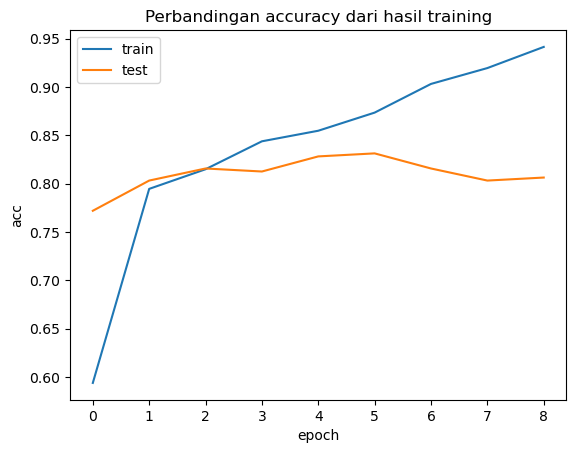

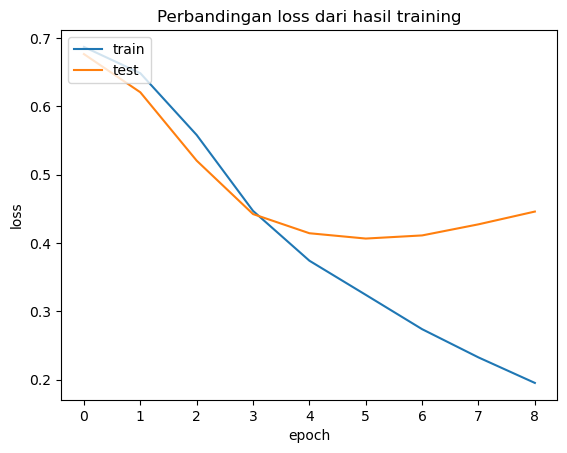

In [39]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Perbandingan accuracy dari hasil training')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Perbandingan loss dari hasil training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

5/5 - 1s - loss: 0.1662 - accuracy: 0.9602 - precision: 0.9519 - recall: 0.9684 - 837ms/epoch - 167ms/step
2/2 - 0s - loss: 0.4460 - accuracy: 0.8062 - precision: 0.8144 - recall: 0.8144 - 47ms/epoch - 23ms/step
Train accuracy: 96.02
Valid accuracy: 80.62


## LSTM

In [41]:
# Define parameter
# vocab_size = 2000
embedding_dim = 64
n_lstm = 128
drop_lstm = 0.2

# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [42]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           128000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [43]:
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = METRICS)

In [44]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history1 = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
40/40 - 8s - loss: 0.6927 - accuracy: 0.5781 - precision: 0.5479 - recall: 0.8938 - val_loss: 0.6850 - val_accuracy: 0.6469 - val_precision: 0.6500 - val_recall: 0.7006 - 8s/epoch - 204ms/step
Epoch 2/30
40/40 - 4s - loss: 0.6481 - accuracy: 0.6375 - precision: 0.6523 - recall: 0.5719 - val_loss: 0.6587 - val_accuracy: 0.6031 - val_precision: 0.9545 - val_recall: 0.2515 - 4s/epoch - 94ms/step
Epoch 3/30
40/40 - 4s - loss: 0.5788 - accuracy: 0.6992 - precision: 0.8351 - recall: 0.4882 - val_loss: 0.5364 - val_accuracy: 0.7812 - val_precision: 0.8345 - val_recall: 0.7246 - 4s/epoch - 94ms/step
Epoch 4/30
40/40 - 4s - loss: 0.4504 - accuracy: 0.8164 - precision: 0.8052 - recall: 0.8294 - val_loss: 0.4490 - val_accuracy: 0.8031 - val_precision: 0.7796 - val_recall: 0.8683 - 4s/epoch - 93ms/step
Epoch 5/30
40/40 - 4s - loss: 0.3334 - accuracy: 0.8797 - precision: 0.8517 - recall: 0.9163 - val_loss: 0.4683 - val_accuracy: 0.8062 - val_precision: 0.8344 - val_recall: 0.7844 - 4s/ep

In [45]:
model1.evaluate(testing_padded, y_test)

10/10 [==============================] - 0s 41ms/step - loss: 0.5027 - accuracy: 0.7875 - precision: 0.7829 - recall: 0.8204


[0.5026618242263794,
 0.7875000238418579,
 0.7828571200370789,
 0.8203592896461487]

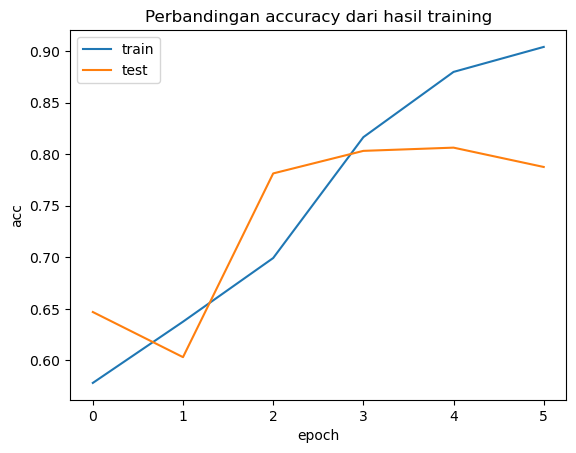

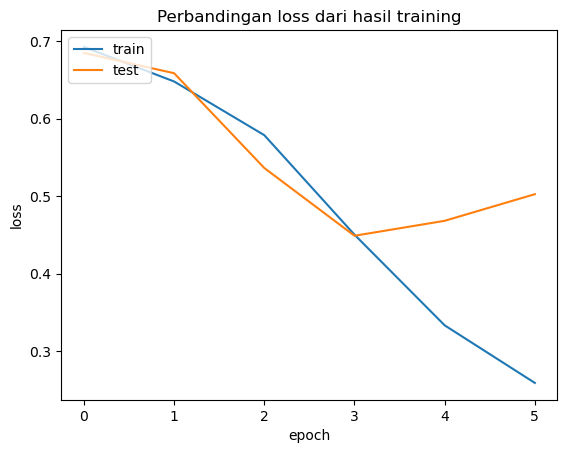

In [46]:
train_loss=history1.history['loss']
val_loss=history1.history['val_loss']
train_acc=history1.history['accuracy']
val_acc=history1.history['val_accuracy']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Perbandingan accuracy dari hasil training')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Perbandingan loss dari hasil training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
train_dense_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model1.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

5/5 - 2s - loss: 0.1935 - accuracy: 0.9461 - precision: 0.9286 - recall: 0.9652 - 2s/epoch - 412ms/step
2/2 - 0s - loss: 0.5027 - accuracy: 0.7875 - precision: 0.7829 - recall: 0.8204 - 234ms/epoch - 117ms/step
Train accuracy: 94.61
Valid accuracy: 78.75


## Bi - LSTM

In [48]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm, return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [49]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           128000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 342,145
Trainable params: 342,145
Non-trainable params: 0
________________________________________________

In [50]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=METRICS)

In [51]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history2 = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
40/40 - 12s - loss: 0.6538 - accuracy: 0.6469 - precision: 0.6463 - recall: 0.6488 - val_loss: 0.5418 - val_accuracy: 0.7656 - val_precision: 0.8538 - val_recall: 0.6647 - 12s/epoch - 308ms/step
Epoch 2/30
40/40 - 7s - loss: 0.4203 - accuracy: 0.8242 - precision: 0.8377 - recall: 0.7994 - val_loss: 0.4235 - val_accuracy: 0.8375 - val_precision: 0.8528 - val_recall: 0.8323 - 7s/epoch - 167ms/step
Epoch 3/30
40/40 - 7s - loss: 0.2955 - accuracy: 0.8859 - precision: 0.8896 - recall: 0.8784 - val_loss: 0.4275 - val_accuracy: 0.8281 - val_precision: 0.8684 - val_recall: 0.7904 - 7s/epoch - 165ms/step
Epoch 4/30
40/40 - 7s - loss: 0.2297 - accuracy: 0.9203 - precision: 0.9194 - recall: 0.9194 - val_loss: 0.4529 - val_accuracy: 0.8250 - val_precision: 0.8323 - val_recall: 0.8323 - 7s/epoch - 166ms/step


In [52]:
model2.evaluate(testing_padded, y_test)

10/10 [==============================] - 1s 57ms/step - loss: 0.4529 - accuracy: 0.8250 - precision: 0.8323 - recall: 0.8323


[0.45287641882896423, 0.824999988079071, 0.832335352897644, 0.832335352897644]

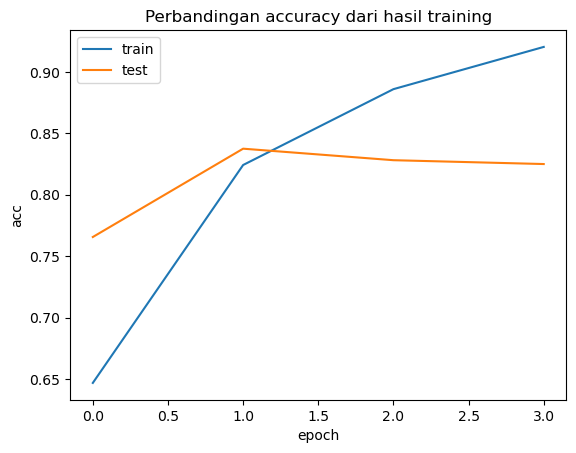

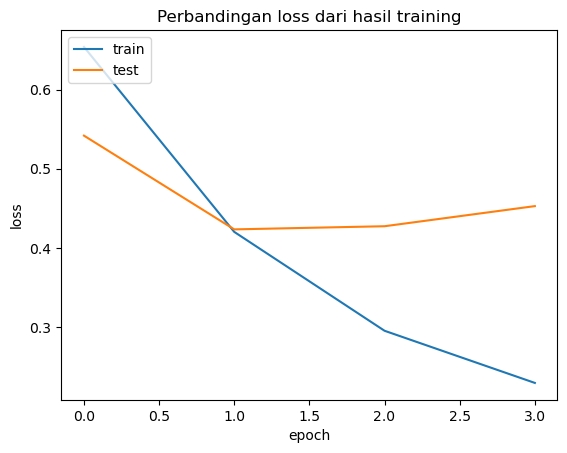

In [53]:
train_loss=history2.history['loss']
val_loss=history2.history['val_loss']
train_acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Perbandingan accuracy dari hasil training')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Perbandingan loss dari hasil training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
train_dense_results = model2.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model2.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

5/5 - 3s - loss: 0.1266 - accuracy: 0.9664 - precision: 0.9728 - recall: 0.9589 - 3s/epoch - 608ms/step
2/2 - 0s - loss: 0.4529 - accuracy: 0.8250 - precision: 0.8323 - recall: 0.8323 - 392ms/epoch - 196ms/step
Train accuracy: 96.64
Valid accuracy: 82.50


## Comparing the four different models

In [55]:
# perbandingan models
print(f"Dense model loss and accuracy: {model.evaluate(testing_padded, y_test)} " )
print(f"LSTM model loss and accuracy: {model1.evaluate(testing_padded, y_test)} " )
print(f"Bi-LSTM model loss and accuracy: {model2.evaluate(testing_padded, y_test)} ")

10/10 [==============================] - 0s 5ms/step - loss: 0.4460 - accuracy: 0.8062 - precision: 0.8144 - recall: 0.8144
Dense model loss and accuracy: [0.44598954916000366, 0.8062499761581421, 0.8143712282180786, 0.8143712282180786] 
10/10 [==============================] - 0s 41ms/step - loss: 0.5027 - accuracy: 0.7875 - precision: 0.7829 - recall: 0.8204
LSTM model loss and accuracy: [0.5026618242263794, 0.7875000238418579, 0.7828571200370789, 0.8203592896461487] 
10/10 [==============================] - 1s 57ms/step - loss: 0.4529 - accuracy: 0.8250 - precision: 0.8323 - recall: 0.8323
Bi-LSTM model loss and accuracy: [0.45287641882896423, 0.824999988079071, 0.832335352897644, 0.832335352897644] 


10/10 [==============================] - 1s 53ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       153
           1       0.83      0.83      0.83       167

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320



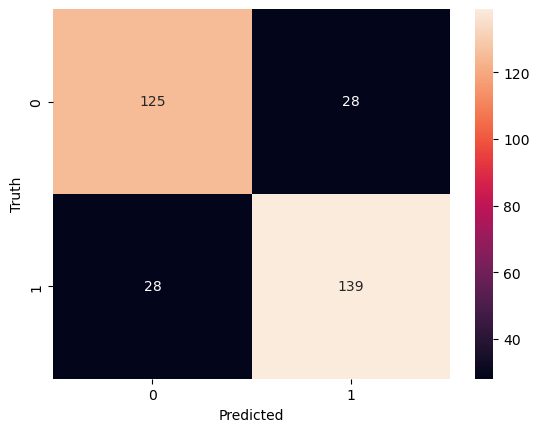

In [63]:
y_predicted = model2.predict(testing_padded)
y_predicted = y_predicted.flatten()

import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test, y_predicted)
cm 

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_test, y_predicted))

In [57]:
predict_text = ["atlet jatim sunoto terminator tempur international championship blood berita surabayasurya surabaya sunoto atlet jawa timur berlaga pertarungan kelas dunia championship blood pertarungan seni bela campuran martial kelas dunia hadir layar kaca jumat februari sunoto menghadapi juara myanmar tial thang tiket kelas bantam championship sunoto juara indonesia jawa timur diakui kemampuannya komunitas indonesia sunoto menjalani debut profesionalnya tampil championship julukan terminator mempertajam kemampuannya meraih kemenangan kariernya championship menjalani pemusatan latihan bali atlet tanah deddy sudarijanto hadirnya laga championship blood layar kaca indonesia upaya mengembangkan tontonan menarik menghibur mendorong potensi olahraga bela indonesia kemampuan atlet atlet kelas dunia inspirasi motivasi atlet olahraga bela indonesia kompetisi dunia championship blood kali indonesia memiliki wakilnya bertarung level deddy kamis kompetisi seni bela campuran martial championship dikenal nama fighting championship championship ajang pengembangan atlet beladiri berbasis singapura diluncurkan juli sunoto bertekad mengerahkan kemampuannya menghadapi tial thang ajang championship blood singapore indoor stadium atlet lawannya myanmar berlatih sanford amerika serikat bernaungnya petarung dunia aung sang brandon vera vitor belfort michael chandler beralih tial thang juara gulat myanmar berhasil mengoleksi ratusan kemenangan berkiprah negaranya sunoto gentar takut makan nasi makan nasi kecuali makan kemenyan sunoto",
                "KRITERIA Calon Persebaya Surabaya Sempat Dibocorkan Azrul Ananda Petinggi PSIS Termasuk SURYA Azrul Ananda ternyata sempat membocorkan kriteria calon Persebaya Surabaya yang akan menggantikannya diungkapkan anak Dahlan Iskan dalam tayangan channel youtube Persebaya Surabaya Saat Azrul menyatakan mundur dari jabatan Persebaya Surabaya Jumat hadapan Bonek awak media Bocoran terkait kriteria calon Persebaya Surabaya terungkap saat Azrul mendapat pertanyaan bagaimana nasib Persebaya siapa yang memimpin nantinya Baca juga SOSOK Pengganti Azrul Ananda Persebaya Surabaya Terjawab Petinggi PSIS Semarang Diisukan MerapatAzrul menyatakan tidak akan meninggalkan Persebaya Surabaya begitu saja akan memastikan Persebaya Surabaya tetap Surabaya sebisa mungkin stakeholdernya adalah orang Surabaya Spiritnya akan sama bahwa harus tetap Surabaya tidak boleh kemana mana harus dikawal sebisa mungkin stakeholdernya harus orang Surabaya ujar Azrul tegas Berikut video selengkapnya Petinggi PSIS Termasuk Seperti diketahui Azrul Ananda telah memutuskan untuk mundur dari jabatan Persebaya Surabaya pada Jumat lalu Meski telah mundur tetapi anak dari Dahlan Iskan masih akan bertanggung jawab hingga Liga berakhir Sosok pengganti Azrul Ananda Persebaya Surabaya masih belum diketahui hingga saat Kabar beredar Petinggi PSIS Semarang Junianto dikaitkan sebagai sosok pengganti Azrul Ananda tersebut muncul usai putranya yaitu Fardhan Nandana menyebutkan bahwa Junianto telah ditunggu oleh para Bonek ",
                "pertumbuhan ekonomi masuknya investasi negeri terciptanya lapangan kerja permadi pengembangan kawasan industri salah segmen usaha utama perseroan proyek kawasan industri dimiliki intiland sukses mengembangan ngoro industrial park berlokasi mojokerto jawa timur kawasan industri terpadu pengembangannya terbagi tahapan pengembangan tahap meliputi area seluas hektare pengembangan direncanakan seluas hektare mengembangkan kawasan intiland menganut prinsip prinsip keberlanjutan desain pengoperasian pengembangan kawasan industri berupaya mematuhi kaidah kaidah bangunan hijau proses industribersih sistem pengelolaan ketat menjaga keseimbangan alam masyarakat lokasi strategis jalur trans jawa menjadikannya mudah dijangkau kota jakarta semarang surabaya kawasan industri berlokasi kilometer pintu kademan jalan raya pantura mudah dijangkau ditopang infrastruktur jalan",
                "nonton piala dunia live streaming laptop digital surya simak nonton piala dunia lengkap laptop digital gelaran piala dunia qatar minggu pertandingan pembuka piala dunia kali mempertemukan tuan rumah qatar ekuador stadion bayt khor malam menonton piala dunia laptop digital baca download jadwal piala dunia jpeg lengkap pembagian grup babak final baca piala dunia lawan timnas brasil final impian cristiano ronaldoberikut surya merangkumnya nonton piala dunia penggemar sepak bola menyaksikan duel qatar ekuador pertandingan piala dunia aplikasi website vidio vidio opsi paket berlangganan penggemar sepak bola menyaksikan pertandingan piala dunia paket berlangganan vidio menonton jenis perangkat televisi paket langganan memungkinan penonton mengakses pertandingan piala dunia tablet langganan menonton piala dunia perangkat dihargai khusus tablet kebijakan berlangganan paket world vidio ditonton perangkat konten world tersedia desember",
                "gudang penimbunan solar tuban digerebek polisi kembangkan jaringan pelaku surya tuban satreskrim polres tuban menggerebek gudang penimbunan solar desa minohorejo kecamatan widang kabupaten tuban penggerebekan polisi mengamankan kendaraan drum berisi solar bersubsidi liter kepala satuan reserse kriminal polres tuban gananta dikonfirmasi pembongkaran gudang solar membenarkan terkait penggerebekan solar kamis kemarin dikonfirmasi selasa perwira penemuan gudang penimbun jenis solar subsidi dasar laporan masyarakat diselidiki penyidik pengembangan mengungkap jaringannya disinggung sosok pelaku gananta proses penyelidikan kembangkan barang bukti amankan mobil nopol drum berisi solar drum drum pungkasnya berdasarkan data dihimpun modus pelaku penimbunan solar membawa surat desa keterangan kebutuhan pertanian stasiun pengisian bahan bakar spbu ambil solar spbu gesing kecamatan semanding spbu plumpang pelaku mengambil solar kali menyuruh orang membawa jeriken kapasitas liter solar dibeli ditampung gudang alasan dijual petani diduga dijual proyek pabrik membutuhkan",
                "FERDY SAMBO Menangis Emosi Saat Perintahkan Tembak Brigadir Bripka Menolak Faktanya SURYA Terungkap sederet fakta tentang Bripka mengaku menolak perintah Ferdy Sambo untuk menembak Brigadir Menurut Bripka Ferdy Sambo menangis emosi saat melontarkan perintah tersebut Bripka juga menyebut Ferdy Sambo sempat dalam kondisi terguncang hingga menangis dibeberkan oleh Pengacara Bripka Ricky Rizal Erman Umar berdasarkan kesaksian kliennya Baca juga Alasan Brigadir Khianati Ferdy Sambo Peran Istri Terima Dijerat Pembunuhan BerencanaBerikut rangkuman fakta selengkapnya melansir dari Tribunnews dalam artikel Bripka Tolak Permintaan Ferdy Sambo untuk Tembak Brigadir Kini Balik Arah dari Skenario Ferdy Samo nangis emosiPengacara Bripka Ricky Rizal Erman Umar mengungkap kesaksian kliennya saat dipanggil Ferdy Sambo ketika berada rumah pribadi Irjen Ferdy Sambo Jalan Saguling Jakarta Saat Ferdy Sambo bertanya kepada kepada Bripka mengenai yang terjadi Magelang Saguling dipanggil Dipanggil Ferdy Sambo tanya kejadian kejadian Magelang Kamu tahu enggak Enggak tahu dilecehkan pelecehan terhadap sambil nangis emosi Saya enggak tahu kata Erman Lobi Bareskrim Polri Jakarta Kamis Menurut Erman ruangan juga Putri Istri Ferdy Sambo juga mengatakan bahwa Yosua melakukan pelecehan terhadap dirinya kuat mentalKemudian saat Ferdy Sambo menanyakan langsung kepada Bripka Ricky kesanggupannya menembak Brigadir ",
                ]
#0
#1
#0
#1
#0
#1

def predict_clickbait(predict_text):

    new_seq = tokenizer.texts_to_sequences(predict_text)
    padded = pad_sequences(new_seq,
                           maxlen = max_len,
                           padding = padding_type,truncating = trunc_type
                        )
    return(model.predict(padded))
predict_clickbait(predict_text)

1/1 [==============================] - 0s 78ms/step


array([[0.06917265],
       [0.9813052 ],
       [0.01977103],
       [0.8969099 ],
       [0.21766806],
       [0.9846297 ]], dtype=float32)

In [58]:
# # Save model
# pickle.dump(model, open("modelDense.pkl", "wb"))
# pickle.dump(model1, open("modelLSTM.pkl", "wb"))
# pickle.dump(model2, open("modelBiLSTM.pkl", "wb"))